In [140]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

sys.path.append('/Users/rdgao/Documents/code/research/SpaceRecon/')
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV/')
sys.path.append('/Users/rdgao/Documents/code/research/fooof/')

from fooof import FOOOF
from fooof import FOOOFGroup
from neurodsp import sim, spectral
from nlds import delayembed as de
from nlds import dfa, utils

font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
def compute_features(data, fs, fooof_range=(2,200), ac_max_lag=500, dfa_n_scales=10, dfa_min_scale=0.01, dfa_max_scale=1):
    n_chans = data.shape[0]
    # compute PSDs
    f_axis, PSD = spectral.compute_spectrum(data,fs)
    PSD=PSD.T

    # FOOOF PSDs without knee
    fg = FOOOFGroup(max_n_peaks=0)
    fg.fit(freqs=f_axis, power_spectra=PSD.T, freq_range=fooof_range)
    fit_exp_lin = fg.get_all_data('aperiodic_params', 'exponent')
    
    # FOOOF PSDs with knee
    fg_kn = FOOOFGroup(aperiodic_mode = 'knee', max_n_peaks=0)
    fg_kn.fit(freqs=f_axis, power_spectra=PSD.T, freq_range=fooof_range)
    fit_knee = fg_kn.get_all_data('aperiodic_params', 'knee')
    fit_exp_kn = fg_kn.get_all_data('aperiodic_params', 'exponent')

    # compute power at knee frequency
    P_knee = [PSD[np.argmin(np.abs((f_axis-(fit_knee[i]**0.5)))),i] for i in range(n_chans)]

    # compute autocorrelation & DFA
    AC = []
    DF = []
    alphas = np.zeros(n_chans)
    for i in range(n_chans):
        t_ac, ac = de.autocorr(data[i,:],max_lag=ac_max_lag)
        AC.append(ac)
        t_scales, df, alphas[i] = dfa.dfa(data[i,:],fs, dfa_n_scales, dfa_min_scale, dfa_max_scale)
        DF.append(df)
    
    AC = np.array(AC)
    DF = np.array(DF)    
    return f_axis, PSD, fit_exp_lin, fit_exp_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas

def tau_from_knee(knee):
    return np.sqrt(1/knee)/(2*np.pi)

### Timescale and 1/f
Power spectra of the Lorentzian form:

$$ P(f) = {A\over(k+f^2)} $$

have a characteristic timescale. Below I'm exploring the relationship between the timescale in time domain, directly defined by the decay time constant of the kernel and the power law exponent ('slope') and 'knee' measured in the frequency domain.

In [149]:
fs = 2000.
t_sim = 2.
t_ker = np.arange(0,t_sim,1/fs)
t_r = 0
t_ds = np.arange(0.005,0.08,0.01)
f_to_plot=200
kernels = []
for t_d in t_ds:
    ker = sim.make_synaptic_kernel(t_sim, fs, tau_r=t_r, tau_d=t_d)
    kernels.append(ker/ker[0])

kernels = np.array(kernels).T
f_axis = np.fft.fftfreq(len(t_ker), 1/fs)[:int(np.floor(len(t_ker)/2))]
PSDs = (np.abs(sp.fft(kernels, axis=0))**2)[:len(f_axis)]
fooof = FOOOFGroup(aperiodic_mode = 'knee', max_n_peaks=0)
fooof.fit(freqs=f_axis, power_spectra=PSDs.T,freq_range=(2,200))
fit_knee = fooof.get_all_data('aperiodic_params', 'knee')
fit_exp = fooof.get_all_data('aperiodic_params', 'exponent')
print(fit_exp)
print(fit_knee**0.5)
P_knee = [PSDs[np.argmin(np.abs((f_axis[:f_to_plot]-(fit_knee[i]**0.5)))),i] for i in range(len(t_ds))]

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[1.97888396 1.98510201 1.98685546 1.98770381 1.98820006 1.98852024
 1.98873974 1.98889668]
[30.4011936  10.25159362  6.15911564  4.39444222  3.40958845  2.78010365
  2.34224545  2.01945232]


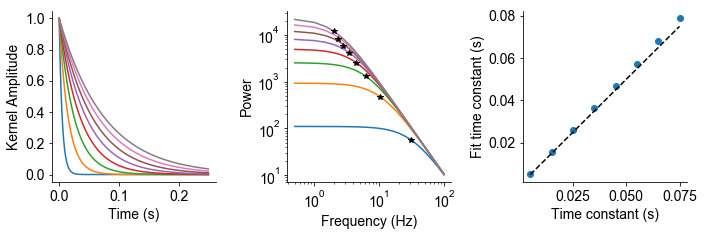

In [150]:
plt.figure(figsize=(10,3.5))
plt.subplot(1,3,1)
plt.plot(t_ker[:500], kernels[:500,:])
plt.xlabel('Time (s)')
plt.ylabel('Kernel Amplitude')
plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot], PSDs[:f_to_plot,:]);
plt.loglog(fit_knee**0.5,P_knee, '*k')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.subplot(1,3,3)
plt.plot(t_ds,np.sqrt(1/fit_knee)/(np.pi*2), 'o')
plt.plot(t_ds, t_ds, 'k--')
plt.xlabel('Time constant (s)')
plt.ylabel('Fit time constant (s)')
[[a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)] for a in plt.gcf().axes]
plt.tight_layout()

With exponential-decay kernels, we can show analytically that time constant is related to fitted knee parameter: 

$\tau = \frac{1}{2\pi}\sqrt{\frac{1}{C}}$, and 

$f_{knee}\approx\sqrt C$

- http://mathworld.wolfram.com/FourierTransformExponentialFunction.html
- http://www.thefouriertransform.com/pairs/decayingexponential.php

# Noise Simulation
Next, we show the same to be true in simulated colored noise, i.e. convolving the above kernels with white noise.

In [171]:
# simulate noise
T = 60*3
noise = []
for t_d in t_ds:
    noise.append(sim.sim_synaptic_noise(T, fs, tau_d = t_d)[:int(T*fs)])

noise = np.vstack(noise)

# compute features
f_axis, PSD_noise, fit_exp_lin, fit_exp_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas = compute_features(noise, fs, dfa_n_scales=20, dfa_min_scale=0.005, dfa_max_scale=5)

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



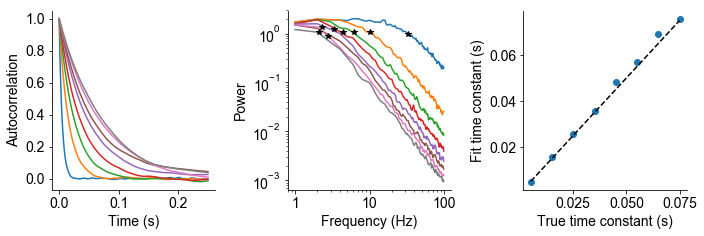

In [172]:
f_to_plot=100
fit_taus = tau_from_knee(fit_knee)
plt.figure(figsize=(10,3.5))
plt.subplot(1,3,1)
plt.plot(t_ac/fs, AC.T)
plt.xlabel('Time (s)')
plt.ylabel('Autocorrelation')
plt.subplot(1,3,2)
plt.loglog(f_axis[:f_to_plot],PSD_noise[:f_to_plot, :])
plt.loglog(fit_knee**0.5,P_knee, '*k')
plt.xticks([1,10,100], ['1','10','100'])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.subplot(1,3,3)
plt.plot(t_ds,fit_taus, 'o')
plt.plot(t_ds, t_ds, 'k--')
plt.xlabel('True time constant (s)')
plt.ylabel('Fit time constant (s)')
[[a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)] for a in plt.gcf().axes]
plt.tight_layout()

Same conclusion checks out for simulated noise data, as expected.

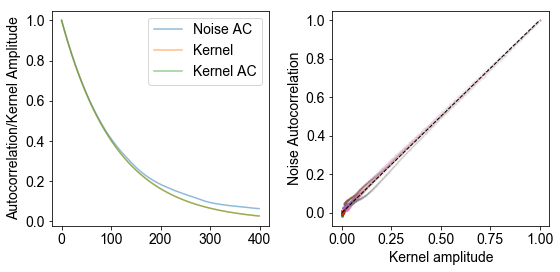

In [173]:
ker = 5
max_lag=400
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(t_ac[:max_lag], AC[ker,:max_lag].T, alpha=0.5, label='Noise AC')
plt.plot(kernels[:max_lag,ker], alpha=0.5, label='Kernel')
plt.plot(de.autocorr(kernels[:,ker],max_lag=max_lag)[1], alpha=0.5, label='Kernel AC')
plt.ylabel('Autocorrelation/Kernel Amplitude')
plt.legend()
plt.subplot(1,2,2)
t_to_plot = 500
plt.plot(kernels[:t_to_plot,:], AC[:,:t_to_plot].T, '.', ms=2, alpha=0.1)
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('Kernel amplitude')
plt.ylabel('Noise Autocorrelation')
plt.tight_layout()

Unexpectedly, **the exponential decay kernel is identical to its own autocorrelation function**. 

I've checked through this with various means, including Wolfram Alpha. Seems to check out. The noise autocorrelation is not exactly identical at the tail, presumably due to stochasticity of the finite length signal. This is weird.

# DFA & autocorrelation timescale
- https://en.wikipedia.org/wiki/Detrended_fluctuation_analysis
- https://atmos.washington.edu/~dennis/552_Notes_6a.pdf
- https://www.physionet.org/tutorials/fmnc/node6.html *
- http://bactra.org/notebooks/power-laws.html

![](../img/dfa_exponent.png)

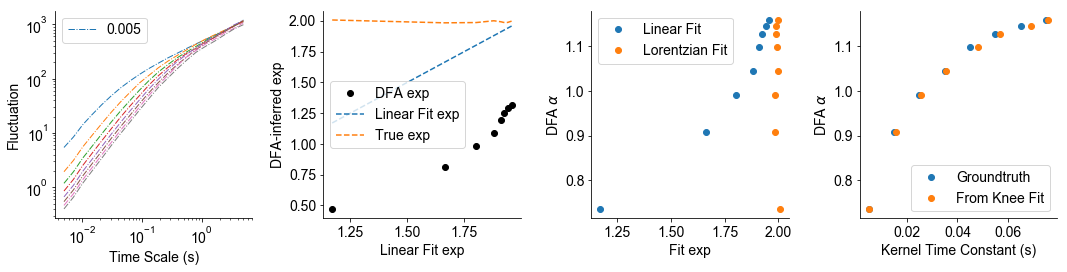

In [174]:
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.loglog(t_scales, DF.T, '-.', lw=1)
plt.legend([t_ds[0]])
plt.xlabel('Time Scale (s)')
plt.ylabel('Fluctuation')

plt.subplot(1,4,2)
plt.plot(fit_exp_lin, 2*alphas-1,  'ko', label='DFA exp')
plt.plot(fit_exp_lin, fit_exp_lin, '--', label='Linear Fit exp')
plt.plot(fit_exp_lin, fit_exp_kn, '--', label='True exp')
plt.xlabel('Linear Fit exp')
plt.ylabel('DFA-inferred exp')
plt.legend()
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(fit_exp_lin, alphas, 'o', label='Linear Fit')
plt.plot(fit_exp_kn, alphas, 'o', label='Lorentzian Fit')
plt.xlabel('Fit exp')
plt.ylabel(r'DFA $\alpha$')
plt.legend()

plt.subplot(1,4,4)
plt.plot(t_ds, alphas, 'o', label='Groundtruth')
plt.plot(fit_taus, alphas, 'o', label='From Knee Fit')
plt.legend()
plt.xlabel('Kernel Time Constant (s)')
plt.ylabel(r'DFA $\alpha$');
[[a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)] for a in plt.gcf().axes];

Linear fit exponent estimates are corrupted by the existence of a knee at lower frequencies, which also corrupts the DFA estimates at longer timescales (low freq = long timescale), i.e., $\beta=2\alpha-1$, where $\beta$ is the PSD exponent. 

As a result DFA computed exponent, based on the relationship , does not match PSD estimated exponent, and neither match the true exponent ($\beta = 2$, second panel). It seems that $\alpha$ would be consistent at shorter timescales (< 0.1s), which makes sense since the smallest kernel is at 5ms, which does not introduce longer term correlations.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



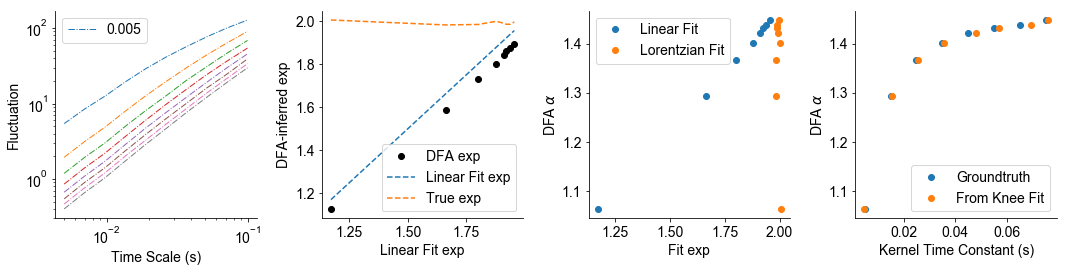

In [175]:
#f_axis, PSD_noise, fit_exp_lin, fit_exp_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas = compute_features(noise, fs, dfa_n_scales=10, dfa_min_scale=1, dfa_max_scale=5)
f_axis, PSD_noise, fit_exp_lin, fit_exp_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas = compute_features(noise, fs, dfa_n_scales=10, dfa_min_scale=0.005, dfa_max_scale=0.1)
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.loglog(t_scales, DF.T, '-.', lw=1)
plt.legend([t_ds[0]])
plt.xlabel('Time Scale (s)')
plt.ylabel('Fluctuation')

plt.subplot(1,4,2)
plt.plot(fit_exp_lin, 2*alphas-1,  'ko', label='DFA exp')
plt.plot(fit_exp_lin, fit_exp_lin, '--', label='Linear Fit exp')
plt.plot(fit_exp_lin, fit_exp_kn, '--', label='True exp')
plt.xlabel('Linear Fit exp')
plt.ylabel('DFA-inferred exp')
plt.legend()
plt.tight_layout()

plt.subplot(1,4,3)
plt.plot(fit_exp_lin, alphas, 'o', label='Linear Fit')
plt.plot(fit_exp_kn, alphas, 'o', label='Lorentzian Fit')
plt.xlabel('Fit exp')
plt.ylabel(r'DFA $\alpha$')
plt.legend()

plt.subplot(1,4,4)
plt.plot(t_ds, alphas, 'o', label='Groundtruth')
plt.plot(fit_taus, alphas, 'o', label='From Knee Fit')
plt.legend()
plt.xlabel('Kernel Time Constant (s)')
plt.ylabel(r'DFA $\alpha$')
[[a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)] for a in plt.gcf().axes];

When DFA's max timescale is set to 0.1s, the fluctuation over timescale is much more power law-like (linear in loglog), which also happens to result in inferred PSD exponent estimates, though it looks like it's still off by a constant? This might be a problem in the exponent measurement assuming a linear PSD in loglog.

When run with timescales from 1-10s, all DFA alphas approach 0.5, which is consistent with the flat slope at long timescales (low frequencies) ($\beta=0$)

# Pure power law noise vs. DFA
Next, we can see what happens when true power law noise is simulated, with controlled exponents.

In [176]:
# simulate noise
T = 60*4
exps = -np.arange(0.5,3,0.25)
ac_max_lag,dfa_n_scales, dfa_max_scale=2000,20,4
noise_PL = []
for exp in exps:
    noise_PL.append(sim.sim_variable_powerlaw(T,fs,exp))
noise_PL = np.array(noise_PL)

# compute features
f_axis, PSD_noise, fit_exp_lin, fit_exp_kn, fit_knee, P_knee, t_ac, AC, t_scales, DF, alphas = compute_features(noise_PL, fs, ac_max_lag=ac_max_lag, dfa_n_scales=dfa_n_scales, dfa_max_scale=dfa_max_scale)
exps = -exps

Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 10 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [180]:
# gammas = 2-2*alphas
# ac_pred = np.array([t_ac**(-g*2) for g in gammas[:3]])
# plt.plot(t_ac, ac_pred.T)
# print(alphas, gammas)

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in sqrt


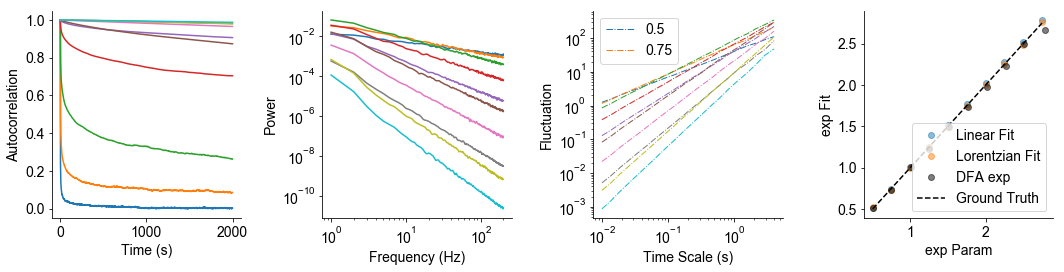

In [181]:
f_to_plot=200
fit_taus = tau_from_knee(fit_knee)
plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.plot(t_ac, AC.T)
plt.xlabel('Time (s)')
plt.ylabel('Autocorrelation')

plt.subplot(1,4,2)
plt.loglog(f_axis[:f_to_plot],PSD_noise[:f_to_plot, :])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

plt.subplot(1,4,3)
plt.loglog(t_scales, DF.T, '-.', lw=1)
plt.legend(exps[:2])
plt.xlabel('Time Scale (s)')
plt.ylabel('Fluctuation')

plt.subplot(1,4,4)
plt.plot(exps,fit_exp_lin, 'o', alpha=0.5, label='Linear Fit')
plt.plot(exps,fit_exp_kn, 'o', alpha=0.5, label='Lorentzian Fit')
plt.plot(fit_exp_lin, 2*alphas-1,  'ko', alpha=0.5, label='DFA exp')
plt.plot(exps,exps, 'k--', label='Ground Truth')
plt.legend()
plt.xlabel('exp Param')
plt.ylabel('exp Fit')

[[a.spines['right'].set_visible(False), a.spines['top'].set_visible(False)] for a in plt.gcf().axes];
plt.tight_layout()

As expected, true power law signals (second panel) are self-similar over timescales of several orders of magnitudes (third panel), and the DFA predicted PSD exponent fits well with fooof-measured PSD exponent (fourth panel). Signal autocorrelation, as predicted in the reference above, also follows a power law.

# Interim summary
So what is slope, knee, and autocorrelation measuring? 

I think starting from the autocorrelation is the most approachable. In all the above simulations, our noise signals have high autocorrelation at small lags (near 0), which means that the signal is similar to itself at nearby timepoints. In other words, the signal does not **change** very much at short timescales - it has little variance. What DFA measures is the rate of dropoff of autocorrelation over different timescales. Hence, in power law signals, the rate of dropoff in autocorrelation follows a power law, which is negative linear in loglog space, well-fit by a line. 

For exponential kernel convolved signals, the dropoff is exponential, since the autocorrelation function itself is also (magically) exponentially decaying. That means at small timescales, the dropoff is very rapid, but they all eventually asymptote to zero correlation - white noise. Hence, we see a piecewise linear function in the DFs that converge to a line in loglog with $\alpha=0.5$. The exponential decay time constant dictates *how quickly* the dropoff plateaus.

Now, we can consider the power spectrum. A handy rule to keep in mind is Parceval's theorem: total signal energy in time domain is equal to the energy in frequency domain. In this case, energy is just the sum of squares, or n\*var(x). One way to think about what the Fourier transform does is that it partitions the signal's variance into orthogonal bases - the complex sinusoids. It's like PCA, but the eigenvectors are sinusoids of different frequency. In other words, power at each frequency is how much of the signal's variance lives in that frequency, or timescale.

Now we can relate the autocorrelation function to the power spectrum: if a signal does not *vary* a lot at short timescales, that means only a small proportion of its variance is in the higher frequencies. This is not mathematically precise, but if you look at the autocorrelation function at lag 1, it's almost 1, which means the signal is basically correlated with a lag-1 version of itself. So there is close to no variance at the highest frequency sampled - Nyquist frequency. Moving towards longer timescales (larger lags), the autocorrelation drops off, hence most of the signals variance is in the lower frequencies. The knee in the power spectrum is mathematically equivalent - as we saw above - to the exponential time constant. It's called the characteristic timescale.

# Follow up questions
###### How would mixing pure power law and exponential decay kernel noise effect DFA and exponent? 
It should be identical to the exponential decay noise case, except with a decrease in exponent at all frequencies, i.e., multiplying a power law and a Lorentzian spectrum. The same should hold for DF across timescales, converging to some other value of $\alpha$, instead of 0.5.

---
    
###### How would adding oscillations to the noise, in both cases, affect DFA and exponent?
Oscillation introduces a bump in the spectrum, and it should also introduce a bump, or some other kind of discontinuity, at the specific timescale that is the frequency of the oscillation. This is because the autocorrelation itself would have an oscillatory component superimposed on the exponential/power law decay, meaning there is a *privileged* timescale where autocorrelation is higher than you would expect for just the noise component.

---
###### How would non-sinusoidal and bursting oscillations affect DFA and exponent?
NS oscillations should produce a non-sinusoidal AC function. If the oscillation is stationary, the AC function should be periodic as well. However, if the frequency is not constant, or if it's bursting, then the ON-OFF periods themselves should introduce long-range correlation, but at much longer timescales.

--- 
###### More importantly, what kind of noise is neural data, exponential (Lorentzian) or power law? 
This is an empirical question, but anecdotally, LFP and ECoG spectra often include a knee, hence there is a characteristic timescale. In the EEG/MEG, it could be the case that spatial summation has further dampened higher frequencies, artificially moving the knee to frequencies lower than what we traditionally look at in the PSD (<1Hz).

One empirical test of power law vs. lorentzian is to look at the fit exponent vs. the DFA transformed exponent. For true power law, the mathematical relation should hold exactly. If not, it means there was a discontinuity in the DFs or the power spectrum, or both. Pragmatically, DFA computed at long time scales (e.g. 10s) should contain the exact same information as the power spectrum computed with 10s windows, thus revealing ultra-low frequency discontinuities.

---
###### In a biophysical model, does excitation/inhibition change the timescale or exponent?
Intuitively, I would think inhibition shortens time constant, as long as they are unsynchronized. Given the same amount of excitation, synchronization should shorten time constant.